In [1]:
import pandas as pd
import numpy as np
import torch
from time import sleep
from collections import deque
import random

np.set_printoptions(precision=2)

In [2]:
import gym

environment = gym.make('CartPole-v0')

In [14]:
environment.action_space

Discrete(2)

In [43]:
environment.action_space.sample()

1

In [16]:
environment.observation_space

Box(4,)

In [44]:
initial_state = environment.reset()
initial_state

array([ 0.04, -0.02,  0.01,  0.04])

In [45]:
environment.step(action=1)

(array([ 0.04,  0.18,  0.01, -0.25]), 1.0, False, {})

In [20]:
environment = gym.make('CartPole-v0')

state = environment.reset()
done = False
while not done:
    action = environment.action_space.sample()
    state, reward, done, info = environment.step(action=action)

In [21]:
environment = gym.make('CartPole-v0')

state = environment.reset()
done = False
while not done:
    action = environment.action_space.sample()
    state, reward, done, info = environment.step(action=action)
    environment.render()
    sleep(0.1)
environment.close()

In [22]:
environment = gym.make('CartPole-v0')

for episode in range(350):
    state = environment.reset()
    done = False
    while not done:
        action = environment.action_space.sample()
        state, reward, done, info = environment.step(action=action)

In [22]:
environment = gym.make('CartPole-v0')

cumulative_rewards = []
for episode in range(350):
    cumulative_reward = 0
    state = environment.reset()
    done = False
    while not done:
        action = environment.action_space.sample()
        state, reward, done, info = environment.step(action=action)
        cumulative_reward += reward
    cumulative_rewards.append(cumulative_reward)

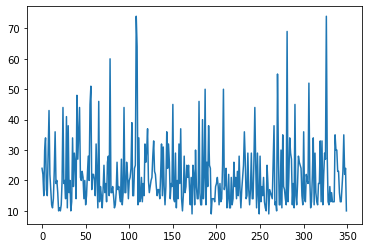

In [23]:
pd.Series(cumulative_rewards).plot()

In [24]:
# state = environment.reset()
# done = False
# while not done:
#     action = agent.select_action(state)
#     state, reward, done, info = environment.step(action=action)

In [25]:
class Agent:
    def __init__(self, policy):
        self._policy = policy
        
    def select_action(self, state):
        distribution = self._policy.get_distribution(state)
        return np.argmax(distribution)

In [26]:
class Agent:
    def __init__(self, policy):
        self._policy = policy

    def select_action(self, state, epsilon=0.):
        if np.random.uniform() < epsilon:
            return np.random.choice([0,1])
        distribution = self._policy.get_distribution(state)
        return np.argmax(distribution)

In [27]:
class Policy:
    def __init__(self, state_dimension, num_actions):
        self.model = torch.nn.Sequential(
            torch.nn.Linear(state_dimension, 50), 
            torch.nn.ReLU(), 
            torch.nn.Linear(50, num_actions)
        )
    
    def get_distribution(self, state):
        state = torch.Tensor(state)
        values = self.model(state)
        distribution = torch.softmax(values, dim=0)
        return distribution.data.cpu().numpy()

In [28]:
class Policy:
    def __init__(self, state_dimension, num_actions):
        self.model = torch.nn.Sequential(
            torch.nn.Linear(state_dimension, 50), 
            torch.nn.ReLU(), 
            torch.nn.Linear(50, num_actions)
        )
    
    def get_distribution(self, state):
        with torch.no_grad():
            self.model.eval()
            state = torch.Tensor(state)
            values = self.model(state)
            distribution = torch.softmax(values, dim=0)
        return distribution.data.cpu().numpy()

In [29]:
policy = Policy(state_dimension=4, num_actions=2)
agent = Agent(policy=policy)

state = environment.reset()
done = False
while not done:
    action = agent.select_action(state=state)
    state, reward, done, info = environment.step(action=action)

In [30]:
policy = Policy(state_dimension=4, num_actions=2)
agent = Agent(policy=policy)

for episode in range(350):
    state = environment.reset()
    done = False
    while not done:
        action = agent.select_action(state=state, epsilon=0.1)
        state, reward, done, info = environment.step(action=action)

In [30]:
policy = Policy(state_dimension=4, num_actions=2)
agent = Agent(policy=policy)

cumulative_rewards = []
for episode in range(350):
    cumulative_reward = 0
    state = environment.reset()
    done = False
    while not done:
        action = agent.select_action(state=state, epsilon=0.1)
        state, reward, done, info = environment.step(action=action)
        cumulative_reward += reward
    cumulative_rewards.append(cumulative_reward)

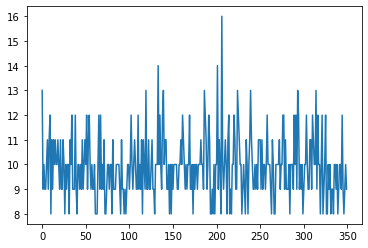

In [31]:
pd.Series(cumulative_rewards).plot()

In [52]:
from collections import deque

class Dataset:
    def __init__(self, max_length):
        self._memory = deque(maxlen=max_length)
    
    def push(self, data):
        self._memory.append(data)
    
    def sample(self, batch_size):
        return random.sample(self._memory, min(batch_size, len(self._memory)))

In [56]:
policy = Policy(state_dimension=4, num_actions=2)
agent = Agent(policy=policy)
dataset = Dataset(max_length=10_000)

for episode in range(350):
    state = environment.reset()
    done = False
    while not done:
        action = agent.select_action(state=state, epsilon=0.1)
        next_state, reward, done, info = environment.step(action=action)
        dataset.push((state, action, reward, next_state, done))
        state = next_state

In [58]:
state, action, reward, next_state, done = dataset.sample(1)[0]

# Convert types
state = torch.Tensor(state)
next_state = torch.Tensor(next_state)

# Compute loss
q = policy.model(state)[action]
next_values = policy.model(next_state)

if not done:
    loss = (q - reward - next_values.max()) ** 2
else:
    loss = (q - reward) ** 2

In [65]:
class Learner:
    def __init__(self, policy, batch_size):
        self.policy = policy
        self.batch_size = batch_size
        self.optimizer = torch.optim.Adam(policy.model.parameters(), lr=1e-2)
        
    def update(self, dataset):
        self.policy.model.train()
        mini_batch = dataset.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*mini_batch)
        
        # Convert types
        states = torch.stack(list(map(torch.Tensor, states)))
        next_states = torch.stack(list(map(torch.Tensor, next_states)))
        rewards = torch.Tensor(rewards)
        actions = torch.LongTensor(actions)
        dones = torch.Tensor(dones)
        
        # Compute loss
        values = self.policy.model(states)
        qs = values.gather(dim=1, index=actions.view(-1, 1)).view(-1)

        next_values = self.policy.model(next_states)
        targets = rewards + next_values.max(dim=1).values*(1. - dones).view(-1)
        
        loss = ((qs - targets.detach()) ** 2).mean()
        
        # Gradient descent
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [ ]:
environment = gym.make('CartPole-v0')

policy = Policy(state_dimension=4, num_actions=2)
agent = Agent(policy=policy)
dataset = Dataset(max_length=10_000)
learner = Learner(policy=policy, batch_size=16)

for episode in range(350):
    state = environment.reset()
    done = False
    while not done:
        action = agent.select_action(state, 0.1)
        next_state, reward, done, info = environment.step(action=action)
        dataset.push((state, action, reward, next_state, done))
        state = next_state
        learner.update(dataset)

## Train until winning 5 times in a row

In [66]:
from tqdm.auto import tqdm

In [67]:
import copy

In [74]:
environment = gym.make('CartPole-v0')

policy = Policy(state_dimension=4, num_actions=2)
agent = Agent(policy=policy)
dataset = Dataset(max_length=10_000)
learner = Learner(policy=policy, batch_size=16)
agents = []

cumulative_rewards = []
is_winner = False
for episode in tqdm(range(35000)):
    if is_winner:
        break
    cumulative_reward = 0
    # run episode
    state = environment.reset()
    done = False
    while not done:
        action = agent.select_action(state, epsilon=0.15)
        next_state, reward, done, info = environment.step(action=action)
        dataset.push((state, action, reward, next_state, done))
        state = next_state
        learner.update(dataset)
        cumulative_reward += reward
    cumulative_rewards.append(cumulative_reward)

    # evaluate agent
    if episode % 25 == 0:
        agents.append(copy.deepcopy(agent))
        for _ in range(5):
            total_reward = 0
            state = environment.reset()
            done = False
            while not done:
                action = agent.select_action(state)
                state, reward, done, info = environment.step(action=action)
                total_reward += reward
            if total_reward < 190:
                is_winner = False
                break
            is_winner = True

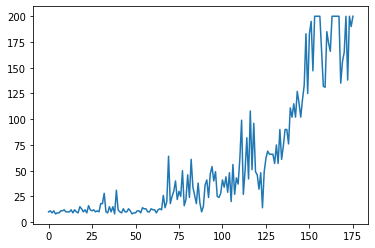

In [75]:
pd.Series(cumulative_rewards).plot()

In [79]:
from gym import wrappers


environment = gym.make('CartPole-v0')

for i, a in enumerate([agents[0]] + agents[-5:]):
    environment = wrappers.Monitor(environment, f'./videito_{i}', force=True)
    state = environment.reset()
    done = False
    while not done:
        action = a.select_action(state)
        state, reward, done, info = environment.step(action=action)
        environment.render()
        sleep(0.1)
    environment.close()

In [71]:
agents